In [31]:
from calcimetry.mongo_api import MongoInfo
from calcimetry.thumbnail_api import ThumbnailAPI
from PIL import Image
import matplotlib.pyplot as plt
import io
import random
import base64

# Load Dataset


random.seed(1)

mongo_info = MongoInfo(host='localhost', port=27010)
thumb_list = []
with ThumbnailAPI(mongo_info=mongo_info) as thumb_api:
    size = thumb_api.size()
    for i in range(50):
        idx = int(random.random()*size)
        thumb, val_1m = thumb_api.read(idx)
        thumb_list.append((thumb, val_1m))
    #plt.imshow(thumb)
    


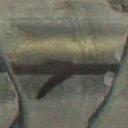
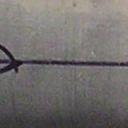
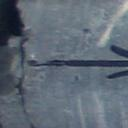
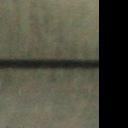
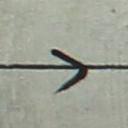
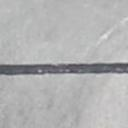
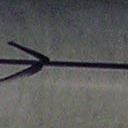
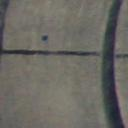
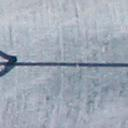
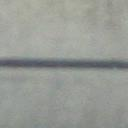
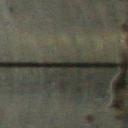
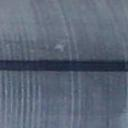
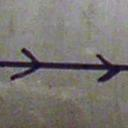
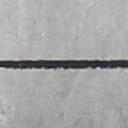
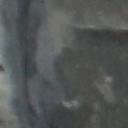
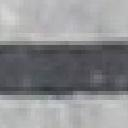
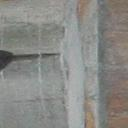
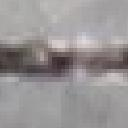
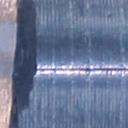
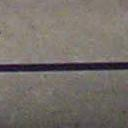
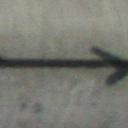
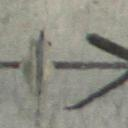
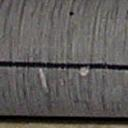
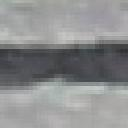
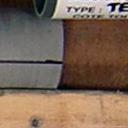
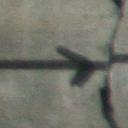
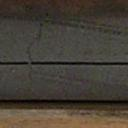
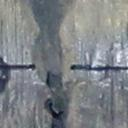
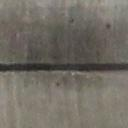
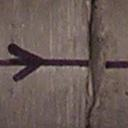
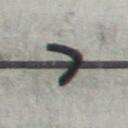
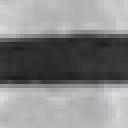
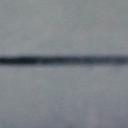
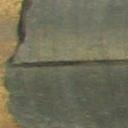
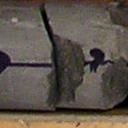
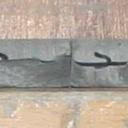
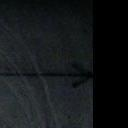
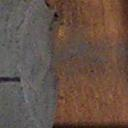
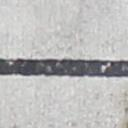
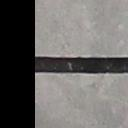
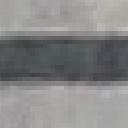
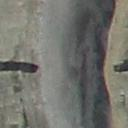
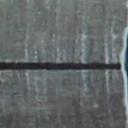
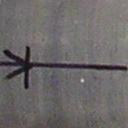
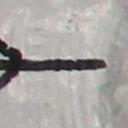
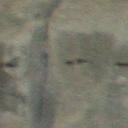
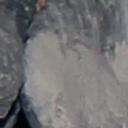
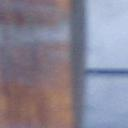
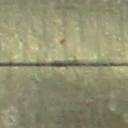
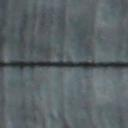

In [33]:
from IPython.display import Image, HTML, display

def to_base64(img: Image):
    byte_array = io.BytesIO()
    img.save(byte_array, format='jpeg')
    return base64.b64encode(byte_array.getvalue()).decode()

html_str = "<div style='display: inline-block; align:justify; border: 1px solid white;'>"
html_str +="<img style='width: 128px; margin: 0px; float: left; ' src='data:image/jpg;base64,%s' />"
html_str +="<P style='text-align: center;'>%s</P>"
html_str +="</div>"

imagesList=''.join( [ html_str % (to_base64(s[0]), s[1]) for s in thumb_list ])
display(HTML(imagesList))

